# ASSIGN GPU


In [9]:
import torch
cuda_enable = True
if torch.cuda.is_available():
  device = torch.device("cuda:0")
  print("GPU")
else:
  device = torch.device("cpu")
  print("CPU")


GPU


# IMPORTING LIBRARIES

In [1]:
import os
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from torch import nn
from pycocotools.coco import COCO
from torchvision import datasets, transforms, models

# Image Dataset Class for Object Detection

In [4]:
import torch
class ImageDataset(torch.utils.data.Dataset):
    def __init__(self, root, annotation, transforms=None, skip_images=None):

        self.root = root
        self.transforms = transforms
        self.skip_images = skip_images if skip_images is not None else []
        self.coco = COCO(annotation)
        self.ids = list(sorted(self.coco.imgs.keys()))

    def __getitem__(self, idx):

        # image ID
        img_id = self.ids[idx]
        # image file_name
        img_file = self.coco.loadImgs(img_id)[0]["file_name"]

        # Skip the image if its filename is in the list of skip_images
        if img_file in self.skip_images:
            return None, None  # Return None for both image and annotations

        try:
            # read_image
            img = Image.open(os.path.join(self.root, img_file))
        except FileNotFoundError:
            print(f"File not found: {os.path.join(self.root, img_file)}")
            return None, None

        # get annotation ID
        ann_ids = self.coco.getAnnIds(imgIds=img_id)
        # read annotation
        anns = self.coco.loadAnns(ann_ids)
        # num of objects in the picture
        num_objs = len(anns)
        # build information about bounding box & area
        boxes = []
        areas = []
        for i in range(num_objs):
            x_min = anns[i]['bbox'][0]
            y_min = anns[i]['bbox'][1]
            x_max = x_min + anns[i]['bbox'][2]
            y_max = y_min + anns[i]['bbox'][3]
            boxes.append([x_min, y_min, x_max, y_max])
            areas.append(anns[i]['area'])

        # transfer information to Tensor
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.ones((num_objs,), dtype=torch.int64)
        img_id = torch.tensor([img_id])
        areas = torch.as_tensor(areas, dtype=torch.float32)
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        # Annotation in dict form
        annotations = {
            "boxes": boxes,
            "labels": labels,
            "image_id": img_id,
            "area": areas,
            "iscrowd": iscrowd
        }

        # apply transformations
        if self.transforms is not None:
            img = self.transforms(img)

        return img, annotations

    def __len__(self):

        return len(self.ids)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Dataset Loading and Transformation

In [5]:
def get_transforms(train):
  trans = []
  if train:
    trans.append(transforms.RandomHorizontalFlip(0.5))
    # trans.append(transforms.RandomAffine(0, shear=10, scale=(0.8, 1.2)))
    # trans.append(transforms.ColorJitter(brightness=1, contrast=1, saturation=1))
  trans.append(transforms.ToTensor())
  return transforms.Compose(trans)

train_data_path = '/content/drive/MyDrive/Colab Notebooks/Images'
coco_path = '/content/drive/MyDrive/Colab Notebooks/train.json'
train_dataset = ImageDataset(root=train_data_path, annotation=coco_path, transforms=get_transforms(train=True))

# collate_fn needs for batch
def collate_fn(batch):
    return tuple(zip(*batch))

train_loader = torch.utils.data.DataLoader(train_dataset, 2, shuffle=True, collate_fn=collate_fn)

loading annotations into memory...
Done (t=0.62s)
creating index...
index created!


# MODEL CREATION

In [6]:
model = models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:02<00:00, 62.7MB/s]


In [7]:
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
# change question to binary classification (human, not human)
num_classes = 2

in_features = model.roi_heads.box_predictor.cls_score.in_features

model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

In [11]:
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)

lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                                step_size=3,
                                                gamma=0.1)

epochs = 12
model = model.to(device)

for _ in range(epochs):
    model.train()
    i = 0
    for imgs, annotations in train_loader:
        i += 1
        imgs = [img.to(device) for img in imgs if img is not None]  # Filter out None values
        annotations = [ann for ann in annotations if ann is not None]  # Filter out None values

        if not imgs:
            continue  # Skip iteration if no valid images

        annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]
        loss_dict = model(imgs, annotations)
        losses = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        print("Iteration: {}; Loss: {}".format(i, losses))
    lr_scheduler.step()



Iteration: 1; Loss: 0.24550752341747284
Iteration: 2; Loss: 0.9564570188522339
Iteration: 3; Loss: 0.9863697290420532
Iteration: 4; Loss: 0.8118302822113037
Iteration: 5; Loss: 0.3674345910549164
File not found: /content/drive/MyDrive/Colab Notebooks/Images/000036.jpg
Iteration: 6; Loss: 0.5270590782165527
File not found: /content/drive/MyDrive/Colab Notebooks/Images/000037.jpg
File not found: /content/drive/MyDrive/Colab Notebooks/Images/000035.jpg
File not found: /content/drive/MyDrive/Colab Notebooks/Images/000010.jpg
Iteration: 8; Loss: 0.3111777603626251
File not found: /content/drive/MyDrive/Colab Notebooks/Images/000019.jpg
Iteration: 9; Loss: 0.5623182654380798
Iteration: 10; Loss: 0.5942243337631226
File not found: /content/drive/MyDrive/Colab Notebooks/Images/000030.jpg
Iteration: 11; Loss: 0.39982888102531433
Iteration: 12; Loss: 1.2442452907562256
Iteration: 13; Loss: 0.35627061128616333
Iteration: 14; Loss: 0.5153088569641113
File not found: /content/drive/MyDrive/Colab No

# MODEL VALIDATION

In [12]:
def im_convert(tensor):
    image = tensor.clone().detach().cpu().numpy()


    image = image.transpose(1, 2, 0)


    image = image * np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5))


    image = image.clip(0, 1)

    return image

[{'boxes': tensor([[264.8076,  21.9225, 383.8945, 367.7605],
        [ 31.6337,  37.4696, 117.3149, 322.4088],
        [113.4699,  33.2394, 196.8096, 315.9286],
        [142.6003,  36.9146, 274.8094, 332.5765],
        [186.1731,  41.1590, 263.5241, 285.9197],
        [ 91.7585,  43.5173, 167.3230, 303.5964],
        [  0.6791,  84.7714,  51.8488, 328.6798],
        [  8.5242,  54.1337,  88.0627, 322.0917],
        [192.7365,  28.8548, 337.6690, 360.8589],
        [211.4043,  35.6087, 288.0079, 299.1140],
        [166.5772,  28.1985, 236.9869, 295.7699],
        [346.5247,  35.3782, 419.2130, 335.0973],
        [  0.0000, 379.8666, 247.8312, 379.9997],
        [308.3050,  35.4314, 401.0113, 339.8470],
        [  1.1391, 144.7732,  38.6069, 297.4062],
        [358.8299, 150.2384, 420.1737, 378.8597]], device='cuda:0',
       grad_fn=<StackBackward0>), 'labels': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9642, 0.9576, 0.9496, 0.4932, 0.

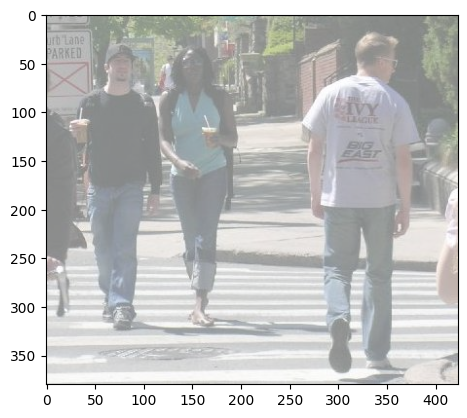

In [75]:
import cv2
from google.colab.patches import cv2_imshow

# use 10.pic to illustrate performance for a single picture.
img = cv2.imread("/content/drive/MyDrive/Colab Notebooks/PNGImages/PennPed00048.png")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# transfer array to pillow format
val_tran = get_transforms(train=False)
im_pil = Image.fromarray(img)
im_pil = val_tran(im_pil)
plt.imshow(im_convert(im_pil))

image = im_pil.to(device)
model_val = model.eval()
output = model([image])
print(output)


Box coordinates: 264.80765 21.92248 383.89447 367.7605
Text position: 264.80765 -78
Box coordinates: 31.633656 37.46955 117.314926 322.40884
Text position: 31.633656 -62
Box coordinates: 113.469925 33.23936 196.80956 315.92856
Text position: 113.469925 -66


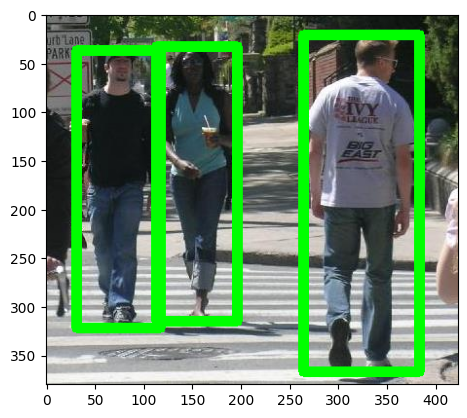

True

In [76]:
scores = output[0]['scores'].detach().cpu().numpy()
boxes = output[0]['boxes'].detach().cpu().numpy()

for i in range(len(scores)):
    if scores[i] > 0.7:  # You can adjust the threshold as needed
        print("Box coordinates:", boxes[i][0], boxes[i][1], boxes[i][2], boxes[i][3])
        img = cv2.rectangle(img, (int(boxes[i][0]), int(boxes[i][1])), (int(boxes[i][2]), int(boxes[i][3])), (0, 255, 0), thickness=10)

        print("Text position:", boxes[i][0], int(boxes[i][1] - 100))
        img = cv2.putText(img, "score: {:.3f}".format(scores[i]), (int(boxes[i][0]), int(boxes[i][1] - 100)), cv2.FONT_HERSHEY_PLAIN, 4, (0, 255, 0), thickness=5)



plt.imshow(img)
plt.show()
img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
cv2.imwrite('output.jpg', img)
